In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker
import pandas as pd
import numpy as np
import scipy.stats
import scipy.integrate as integrate
from sklearn import linear_model
from sklearn.isotonic import IsotonicRegression

from zz_calibration_code import *
from zz_mergingpoint_code import *
from zz_paretowealth_code import *

## Merging point algorithm

This code implements the merging point algorithm as defined in the paper Wealth Survey Calibration Using Income Tax Data.

### 1. The function

In [2]:
def mp(tax,survey,pop_size=None,ts=0,inccol="income",weightcol="weight",gamma=3,beta=30,other_mp=[]):
    """
    This function implements the merging point algorithm in the Wealth Survey Calibration paper by Kolar. 
    It returns the candidate merging points (df_mp_c) and a dataframe that serves as input for the graphs (grid_df).
    Required inputs are the tax & survey datasets, 
    and the absolute total (adult) population.
    See readme for more information.
    """
    survey=survey.rename(columns={inccol:"PInc",weightcol:"Weight"})
    tax=tax.loc[tax.p>=ts/100,:].copy()
    grid_df=getgridformp(tax,survey,pop_size,trustablespan=ts)
    df_mp=getdfforoptimalmp(grid_df)
    df_mp_c=getcandidatemps(df_mp,pop_size,thr=gamma/100,dist=beta/100)
    df_mp.loc[:,"test_stat_pct"]=df_mp.loc[:,"Dist"]/pop_size*100
    df_mp_c.loc[:,"test_stat_pct"]=(df_mp_c.loc[:,"Dist"]/pop_size*100).map('{:.2%}'.format)
    df_mp_c=df_mp_c.sort_values(by="Rank",ascending=False)
    for p in other_mp:
        try:
            df_mp_c=df_mp_c.append(df_mp.loc[df_mp.Rank==p,:])
        except:
            df_mp_c=df_mp_c._append(df_mp.loc[df_mp.Rank==p,:])
    return grid_df,df_mp_c.loc[:,["Rank","test_stat_pct"]].rename(columns={"Rank":"p"})

### 2. Test on sample data

In [3]:
tax=pd.read_excel("tax_sample.xlsx") #dataset has a trustable span from 0.8, but it is not necessary to specify this in the function
survey=pd.read_csv("survey_sample.csv")
pop_size=1000000
grid_df,df_mp_c=mp(tax,survey,pop_size)
print(df_mp_c)

      p test_stat_pct
2  0.90         2.39%
0  0.83         0.60%
1  0.50         2.18%


### 3. Graphs

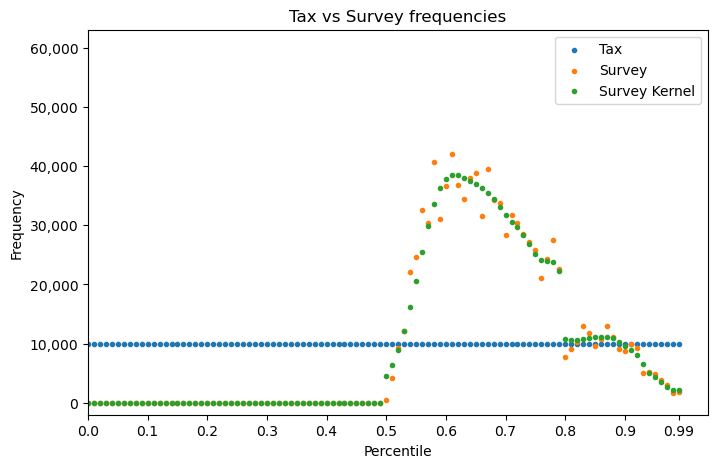

In [4]:
###comparing survey and tax densities
grid_dfj=grid_df.copy()

cond=grid_dfj["Rank"]>0.989
grid99=grid_dfj[cond].sum()
grid99["Rank"]=0.99
grid_dfj=grid_dfj[~cond]
try:
    grid_dfj=grid_dfj.append(grid99,ignore_index=True)
except:
    grid_dfj=grid_dfj._append(grid99,ignore_index=True)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)


x=grid_dfj.Rank
ax.scatter(x.astype('str'),grid_dfj["DensityTax"],label="Tax",marker=".")
ax.scatter(x.astype('str'),grid_dfj["DensitySurvey"],label="Survey",marker=".")
ax.scatter(x.astype('str'),grid_dfj["DensitySurveyKernel"],label="Survey Kernel",marker=".")
ax.legend(loc="upper right")

ax.set_ylim(top=int(grid_dfj.loc[:,["DensitySurvey"]].max().iloc[0])*1.5,bottom=-2000)
#ax.set_ylim(top=700,bottom=-5)
ax.set_xlim(left=0)
ax.set_title(f"Tax vs Survey frequencies")
#format of y axis
ax.get_yaxis().set_major_formatter(
matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

#ticks --- special for this setup
a=x.copy()
cond=[len(str(num))==3 for num in a]
ticks_min=np.array(a)[cond].min()
cond=a>=ticks_min
b=a[cond][::10] #ticks below 0.9
c=x.iloc[[len(x)-1]] #0.99
try:
    d=b.append(c)
except:
    d=b._append(c)
ax.set_xlabel("Percentile")
ax.set_ylabel("Frequency")
plt.xticks(d.index,np.round(d,2),rotation=0)
plt.show()

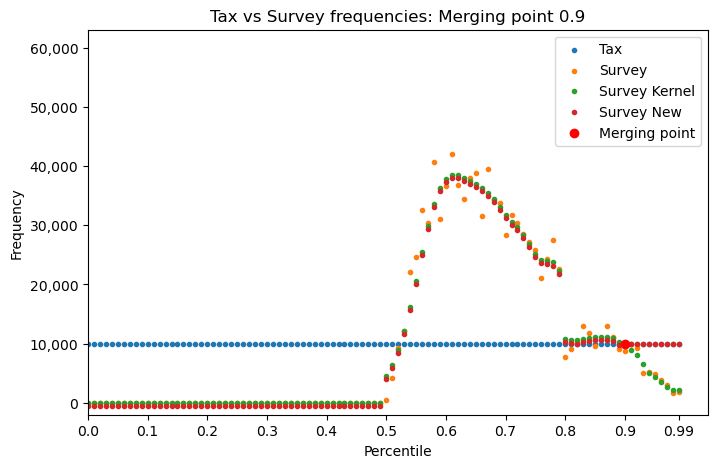

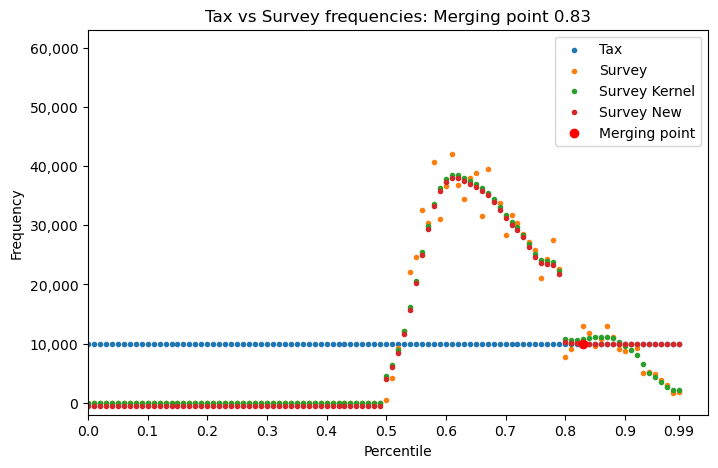

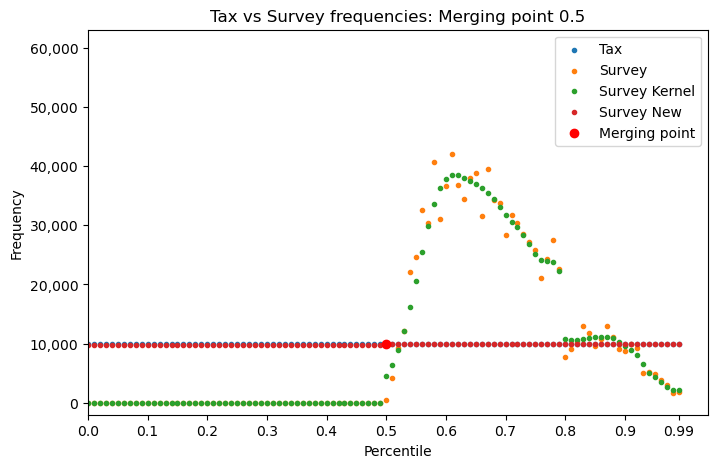

In [5]:
### graphically evaluating each candidate merging point
for p in df_mp_c.p:
    grid_dfj=grid_df.copy()
    optimalmp=p
    cond=grid_dfj["Rank"]>0.989
    grid99=grid_dfj[cond].sum()
    grid99["Rank"]=0.99
    grid_dfj=grid_dfj[~cond]
    try:
        grid_dfj=grid_dfj.append(grid99,ignore_index=True)
    except:
        grid_dfj=grid_dfj._append(grid99,ignore_index=True)
    grid_dfj["DensityNew"]=evaluatemp(optimalmp,grid_dfj)[1]
    
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(1,1,1)
    x=grid_dfj.Rank
    ax.scatter(x.astype('str'),grid_dfj["DensityTax"],label="Tax",marker=".")
    ax.scatter(x.astype('str'),grid_dfj["DensitySurvey"],label="Survey",marker=".")
    ax.scatter(x.astype('str'),grid_dfj["DensitySurveyKernel"],label="Survey Kernel",marker=".")
    ax.scatter(x.astype('str'),grid_dfj["DensityNew"],label="Survey New",marker=".")
    ax.scatter(str(np.round(optimalmp,2)),grid_dfj["DensityTax"][0],label="Merging point",color="red")
    ax.legend(loc="upper right")

    ax.set_ylim(top=int(grid_dfj.loc[:,["DensitySurvey"]].max().iloc[0])*1.5,bottom=-2000)
    #ax.set_ylim(top=700,bottom=-5)
    #ax.set_xlim(left=0.999)
    ax.set_title(f"Tax vs Survey frequencies: Merging point {p}")
    #ax.set_ylim(top=700,bottom=-5)
    ax.set_xlim(left=0)
    #format of y axis
    ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    #ticks --- special for this setup
    a=x.copy()
    cond=[len(str(num))==3 for num in a]
    ticks_min=np.array(a)[cond].min()
    cond=a>=ticks_min
    b=a[cond][::10] #ticks below 0.9
    c=x.iloc[[len(x)-1]] #0.99
    try:
        d=b.append(c)
    except:
        d=b.append(c)
    ax.set_xlabel("Percentile")
    ax.set_ylabel("Frequency")
    plt.xticks(d.index,np.round(d,2),rotation=0)
    plt.show()